# Stablecoin Pool Optimization Backtesting

This notebook provides a complete backtesting framework for the stablecoin pool optimization algorithm. It uses mock data that matches the exact format from the database, allowing you to test and validate the optimization implementation without connecting to the actual database.

## Overview

The notebook includes:
1. **Mock Data Generation**: Creates realistic pool data, token prices, gas fees, and balances
2. **Optimization Testing**: Runs the optimization algorithm with various scenarios
3. **Result Analysis**: Visualizes and analyzes optimization results
4. **Backtesting Scenarios**: Tests different market conditions and parameter configurations

## Usage Instructions

1. Run all cells in order to set up the environment and generate mock data
2. Modify the mock data parameters in the "Mock Data Generation" section to test different scenarios
3. Run optimization tests with different parameter configurations
4. Analyze results using the built-in visualization tools
5. Extend the notebook with your own backtesting scenarios

## Data Structure

The mock data matches the exact database schema:
- **Pools**: `pool_daily_metrics` and `pools` table format
- **Tokens**: `raw_coinmarketcap_ohlcv` table format
- **Balances**: `daily_balances` table format
- **Parameters**: `allocation_parameters` table format

## 1. Setup and Imports

In [1]:
# Install required packages if not already installed
# !pip install pandas numpy matplotlib seaborn cvxpy

import pandas as pd
import numpy as np
import json
import time
from datetime import datetime, date, timedelta
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Mock Data Generation

This section generates realistic mock data that matches the exact database format used by the optimization algorithm.

In [2]:
class MockDataGenerator:
    """Generates mock data for backtesting the optimization algorithm."""
    
    def __init__(self, seed=42):
        """Initialize the mock data generator with a random seed."""
        np.random.seed(seed)
        self.date = date.today()
        
    def generate_pools(self, num_pools=20):
        """Generate mock pool data matching the database format.
        
        Returns:
            pd.DataFrame: Pool data with columns matching pool_daily_metrics and pools tables
        """
        # Define common stablecoin pools
        pool_templates = [
            {
                'symbol': 'USDC-USDT',
                'chain': 'Ethereum',
                'protocol': 'Curve',
                'underlying_tokens': ['USDC', 'USDT']
            },
            {
                'symbol': 'DAI-USDC',
                'chain': 'Ethereum',
                'protocol': 'Curve',
                'underlying_tokens': ['DAI', 'USDC']
            },
            {
                'symbol': 'USDC-DAI-USDT',
                'chain': 'Ethereum',
                'protocol': 'Curve',
                'underlying_tokens': ['USDC', 'DAI', 'USDT']
            },
            {
                'symbol': 'USDC',
                'chain': 'Ethereum',
                'protocol': 'Aave',
                'underlying_tokens': ['USDC']
            },
            {
                'symbol': 'DAI',
                'chain': 'Ethereum',
                'protocol': 'Aave',
                'underlying_tokens': ['DAI']
            },
            {
                'symbol': 'USDT',
                'chain': 'Ethereum',
                'protocol': 'Aave',
                'underlying_tokens': ['USDT']
            },
            {
                'symbol': 'USDC-USDT',
                'chain': 'Polygon',
                'protocol': 'Curve',
                'underlying_tokens': ['USDC', 'USDT']
            },
            {
                'symbol': 'USDC',
                'chain': 'Polygon',
                'protocol': 'Aave',
                'underlying_tokens': ['USDC']
            }
        ]
        
        pools = []
        for i in range(num_pools):
            template = pool_templates[i % len(pool_templates)]
            pool_id = f"pool_{i+1:03d}"
            
            # Generate realistic APY values (1-15%)
            base_apy = np.random.uniform(0.01, 0.15)
            
            # Add some variation based on protocol and chain
            if template['protocol'] == 'Aave':
                base_apy *= 0.9  # Aave typically lower APY
            elif template['protocol'] == 'Curve' and len(template['underlying_tokens']) == 2:
                base_apy *= 1.1  # 2-pool Curve typically higher APY
            
            # Generate realistic TVL values ($100K - $100M)
            base_tvl = np.random.uniform(100000, 100000000)
            
            pools.append({
                'pool_id': pool_id,
                'symbol': template['symbol'],
                'chain': template['chain'],
                'protocol': template['protocol'],
                'underlying_tokens': json.dumps(template['underlying_tokens']),
                'forecasted_apy': base_apy * 100,  # Convert to percentage
                'forecasted_tvl': base_tvl,
                'is_filtered_out': False,
                'is_active': True
            })
        
        return pd.DataFrame(pools)
    
    def generate_token_prices(self, tokens):
        """Generate mock token prices matching the database format.
        
        Args:
            tokens: List of token symbols
            
        Returns:
            Dict: Token prices in USD
        """
        prices = {}
        for token in tokens:
            if token in ['USDC', 'USDT', 'DAI', 'FRAX', 'TUSD', 'BUSD', 'GUSD', 'USDP']:
                # Stablecoins - very close to $1 with small variations
                prices[token] = 1.0 + np.random.normal(0, 0.002)
            elif token == 'ETH':
                # ETH price around $3000 with more volatility
                prices[token] = 3000 + np.random.normal(0, 100)
            elif token == 'WBTC':
                # WBTC price around $60000
                prices[token] = 60000 + np.random.normal(0, 2000)
            else:
                # Other tokens - reasonable price range
                prices[token] = np.random.uniform(0.5, 100)
        
        return prices
    
    def generate_balances(self, tokens, total_aum=1000000):
        """Generate mock wallet and allocation balances.
        
        Args:
            tokens: List of token symbols
            total_aum: Total assets under management in USD
            
        Returns:
            Tuple of (warm_wallet_balances, current_allocations)
        """
        # Generate warm wallet balances (20-40% of total AUM)
        warm_wallet_pct = np.random.uniform(0.2, 0.4)
        warm_wallet_usd = total_aum * warm_wallet_pct
        
        warm_wallet = {}
        remaining_usd = warm_wallet_usd
        
        # Distribute among stablecoins
        stablecoins = [t for t in tokens if t in ['USDC', 'USDT', 'DAI']]
        if stablecoins:
            for i, token in enumerate(stablecoins):
                if i == len(stablecoins) - 1:
                    # Last token gets remaining amount
                    amount_usd = remaining_usd
                else:
                    # Random distribution
                    amount_usd = remaining_usd * np.random.uniform(0.2, 0.5)
                    remaining_usd -= amount_usd
                
                price = 1.0  # Stablecoins are ~$1
                warm_wallet[token] = amount_usd / price
        
        # Generate current allocations (60-80% of total AUM)
        allocated_usd = total_aum - warm_wallet_usd
        current_allocations = {}
        
        # Create some existing allocations
        num_allocations = np.random.randint(3, 8)
        pool_ids = [f"pool_{i+1:03d}" for i in range(num_allocations)]
        
        remaining_allocated_usd = allocated_usd
        for i, pool_id in enumerate(pool_ids):
            if i == len(pool_ids) - 1:
                amount_usd = remaining_allocated_usd
            else:
                amount_usd = remaining_allocated_usd * np.random.uniform(0.1, 0.3)
                remaining_allocated_usd -= amount_usd
            
            # Randomly assign to tokens
            token = np.random.choice(stablecoins if stablecoins else ['USDC'])
            price = 1.0
            amount = amount_usd / price
            
            current_allocations[(pool_id, token)] = amount
        
        return warm_wallet, current_allocations
    
    def generate_gas_fees(self):
        """Generate mock gas fee data.
        
        Returns:
            Tuple: (eth_price_usd, base_fee_transfer_gwei, base_fee_swap_gwei, priority_fee_gwei, min_gas_units)
        """
        eth_price = 3000 + np.random.normal(0, 100)
        base_fee_transfer_gwei = np.random.uniform(5, 15)
        base_fee_swap_gwei = np.random.uniform(20, 40)
        priority_fee_gwei = np.random.uniform(5, 15)
        min_gas_units = 21000
        
        return eth_price, base_fee_transfer_gwei, base_fee_swap_gwei, priority_fee_gwei, min_gas_units
    
    def generate_allocation_parameters(self, custom_overrides=None):
        """Generate mock allocation parameters.
        
        Args:
            custom_overrides: Optional dictionary of parameter overrides
            
        Returns:
            Dict: Allocation parameters
        """
        params = {
            'run_id': f"mock_run_{int(time.time())}",
            'timestamp': datetime.now(),
            'max_alloc_percentage': 0.25,  # 25% max per pool
            'conversion_rate': 0.0004,     # 0.04% conversion fee
            'min_transaction_value': 50.0,  # $50 minimum transaction
            'tvl_limit_percentage': 0.05,  # 5% of pool TVL max
            'min_pools': 5,                # Minimum 5 pools
            
            # Filtering parameters
            'token_marketcap_limit': 1000000000.0,
            'pool_tvl_limit': 100000.0,
            'pool_apy_limit': 0.01,
            'pool_pair_tvl_ratio_min': 0.3,
            'pool_pair_tvl_ratio_max': 0.5,
            
            # Group allocation limits
            'group1_max_pct': 0.35,
            'group2_max_pct': 0.35,
            'group3_max_pct': 0.3,
            
            # Position limits
            'position_max_pct_total_assets': 0.25,
            'position_max_pct_pool_tvl': 0.05,
            
            # APY and volatility limits
            'group1_apy_delta_max': 0.01,
            'group1_7d_stddev_max': 0.015,
            'group1_30d_stddev_max': 0.02,
            'group2_apy_delta_max': 0.03,
            'group2_7d_stddev_max': 0.04,
            'group2_30d_stddev_max': 0.05,
            'group3_apy_delta_min': 0.03,
            'group3_7d_stddev_min': 0.04,
            'group3_30d_stddev_min': 0.02,
            
            # Icebox parameters
            'icebox_ohlc_l_threshold_pct': 0.02,
            'icebox_ohlc_l_days_threshold': 2,
            'icebox_ohlc_c_threshold_pct': 0.01,
            'icebox_ohlc_c_days_threshold': 1,
            'icebox_recovery_l_days_threshold': 2,
            'icebox_recovery_c_days_threshold': 3
        }
        
        # Apply custom overrides if provided
        if custom_overrides:
            params.update(custom_overrides)
        
        return params

print("✓ MockDataGenerator class defined")

✓ MockDataGenerator class defined


## 3. Generate Mock Data

In [3]:
# Initialize mock data generator
generator = MockDataGenerator(seed=42)

# Generate pools
pools_df = generator.generate_pools(num_pools=15)
print(f"Generated {len(pools_df)} pools")
print("\nSample pools:")
display(pools_df.head())

# Extract tokens from pools
tokens = set()
for _, row in pools_df.iterrows():
    underlying_tokens = json.loads(row['underlying_tokens'])
    tokens.update(underlying_tokens)
tokens = list(tokens)
tokens.append('ETH')  # Add ETH for gas fees

print(f"\nTokens in universe: {tokens}")

# Generate token prices
token_prices = generator.generate_token_prices(tokens)
print("\nToken prices:")
for token, price in token_prices.items():
    print(f"  {token}: ${price:.4f}")

# Generate balances
warm_wallet, current_allocations = generator.generate_balances(tokens, total_aum=1000000)
print("\nWarm wallet balances:")
for token, amount in warm_wallet.items():
    print(f"  {token}: {amount:,.2f}")

print("\nCurrent allocations:")
for (pool_id, token), amount in current_allocations.items():
    print(f"  {pool_id} - {token}: {amount:,.2f}")

# Generate gas fees
eth_price, base_fee_transfer, base_fee_swap, priority_fee, min_gas = generator.generate_gas_fees()
print(f"\nGas fee data:")
print(f"  ETH price: ${eth_price:.2f}")
print(f"  Base fee (transfer): {base_fee_transfer:.2f} Gwei")
print(f"  Base fee (swap): {base_fee_swap:.2f} Gwei")
print(f"  Priority fee: {priority_fee:.2f} Gwei")
print(f"  Min gas units: {min_gas}")

# Generate allocation parameters
alloc_params = generator.generate_allocation_parameters()
print("\nKey allocation parameters:")
print(f"  Max allocation per pool: {alloc_params['max_alloc_percentage']:.1%}")
print(f"  TVL limit percentage: {alloc_params['tvl_limit_percentage']:.1%}")
print(f"  Conversion rate: {alloc_params['conversion_rate']:.4%}")
print(f"  Minimum pools: {alloc_params['min_pools']}")

Generated 15 pools

Sample pools:


,pool_id,symbol,chain,protocol,underlying_tokens,forecasted_apy,forecasted_tvl,is_filtered_out,is_active
0,pool_001,USDC-USDT,Ethereum,Curve,"[""USDC"", ""USDT""]",6.867918,9.507636e+07,False,True
1,pool_002,DAI-USDC,Ethereum,Curve,"[""DAI"", ""USDC""]",12.372707,5.990598e+07,False,True
2,pool_003,USDC-DAI-USDT,Ethereum,Curve,"[""USDC"", ""DAI"", ""USDT""]",3.184261,1.568385e+07,False,True
3,pool_004,USDC,Ethereum,Aave,"[""USDC""]",1.631854,8.663100e+07,False,True
4,pool_005,DAI,Ethereum,Aave,"[""DAI""]",8.474049,7.083645e+07,False,True



Tokens in universe: ['USDC', 'DAI', 'USDT', 'ETH']

Token prices:
  USDC: $0.9977
  DAI: $1.0008
  USDT: $0.9988
  ETH: $2970.8306

Warm wallet balances:
  USDC: 111,848.48
  DAI: 53,237.14
  USDT: 171,760.99

Current allocations:
  pool_001 - USDT: 176,822.55
  pool_002 - DAI: 137,079.20
  pool_003 - DAI: 81,202.57
  pool_004 - DAI: 49,597.44
  pool_005 - DAI: 45,731.12
  pool_006 - DAI: 18,353.74
  pool_007 - DAI: 154,366.79

Gas fee data:
  ETH price: $2782.17
  Base fee (transfer): 14.27 Gwei
  Base fee (swap): 34.55 Gwei
  Priority fee: 8.27 Gwei
  Min gas units: 21000

Key allocation parameters:
  Max allocation per pool: 25.0%
  TVL limit percentage: 5.0%
  Conversion rate: 0.0400%
  Minimum pools: 5


## 4. Optimization Implementation

This section includes the optimization algorithm adapted to work with mock data instead of database connections.

In [4]:
# Import optimization classes from the actual implementation
import sys
import os

# Add project root to Python path
sys.path.append(os.getcwd())

try:
    from asset_allocation.optimize_allocations import AllocationOptimizer, calculate_aum, build_token_universe
    print("✓ Successfully imported optimization classes")
except ImportError as e:
    print(f"✗ Failed to import optimization classes: {e}")
    print("Please ensure you're running this from the project root directory")
    print("The asset_allocation module should be available")

✓ Successfully imported optimization classes


In [5]:
# Helper functions for gas fee calculation (from the original implementation)
def calculate_gas_fee_usd(gas_units, base_fee_gwei, priority_fee_gwei, eth_price_usd):
    """Calculate gas fee in USD."""
    total_fee_gwei = gas_units * (base_fee_gwei + priority_fee_gwei)
    gas_fee_usd = total_fee_gwei * 1e-9 * eth_price_usd
    return gas_fee_usd

def calculate_transaction_gas_fees(eth_price_usd, base_fee_transfer_gwei, 
                                   base_fee_swap_gwei, priority_fee_gwei, 
                                   min_gas_units):
    """Calculate gas fees for different transaction types."""
    # Pool allocation/withdrawal gas fee
    pool_transaction_gas_fee_usd = calculate_gas_fee_usd(
        min_gas_units, base_fee_transfer_gwei, priority_fee_gwei, eth_price_usd
    )
    
    # Token swap gas fee
    token_swap_gas_fee_usd = calculate_gas_fee_usd(
        min_gas_units, base_fee_swap_gwei, priority_fee_gwei, eth_price_usd
    )
    
    gas_fees = {
        'allocation': pool_transaction_gas_fee_usd,
        'withdrawal': pool_transaction_gas_fee_usd,
        'conversion': token_swap_gas_fee_usd,
        'transfer': pool_transaction_gas_fee_usd,
        'deposit': pool_transaction_gas_fee_usd
    }
    
    return gas_fees

print("✓ Helper functions defined")

✓ Helper functions defined


## 5. Run Optimization with Mock Data

In [6]:
# Calculate gas fees
gas_fees = calculate_transaction_gas_fees(
    eth_price, base_fee_transfer, base_fee_swap, priority_fee, min_gas
)

print("Gas fees by transaction type:")
for txn_type, fee in gas_fees.items():
    print(f"  {txn_type}: ${fee:.6f}")

# Calculate total AUM
total_aum = calculate_aum(warm_wallet, current_allocations, token_prices)
print(f"\nTotal AUM: ${total_aum:,.2f}")

# Build token universe
token_universe = build_token_universe(pools_df, warm_wallet, current_allocations)
print(f"Token universe: {token_universe}")

# Initialize optimizer
print("\nInitializing optimizer...")
optimizer = AllocationOptimizer(
    pools_df=pools_df,
    token_prices=token_prices,
    warm_wallet=warm_wallet,
    current_allocations=current_allocations,
    gas_fees=gas_fees,
    alloc_params=alloc_params
)

print("✓ Optimizer initialized successfully")

2025-12-07 22:26:41,659 - asset_allocation.optimize_allocations - INFO - Total AUM: $999,729.21
2025-12-07 22:26:41,661 - asset_allocation.optimize_allocations - INFO - Token universe: 3 tokens - ['DAI', 'USDC', 'USDT']
2025-12-07 22:26:41,662 - asset_allocation.optimize_allocations - INFO - Token universe: 3 tokens - ['DAI', 'USDC', 'USDT']
2025-12-07 22:26:41,663 - asset_allocation.optimize_allocations - INFO - Total AUM: $999,729.21
2025-12-07 22:26:41,664 - asset_allocation.optimize_allocations - INFO - Optimizer initialized: 15 pools, 3 tokens, AUM=$999,729.21
2025-12-07 22:26:41,665 - asset_allocation.optimize_allocations - INFO - Parameters: max_alloc=25.0% ($249,932.30 per pool), tvl_limit=5.0%, conversion_rate=0.0400%


Gas fees by transaction type:
  allocation: $1.316443
  withdrawal: $1.316443
  conversion: $2.501245
  transfer: $1.316443
  deposit: $1.316443

Total AUM: $999,729.21
Token universe: ['DAI', 'USDC', 'USDT']

Initializing optimizer...
✓ Optimizer initialized successfully


In [7]:
# Solve optimization problem
print("Solving optimization problem...")
start_time = time.time()

try:
    success = optimizer.solve(verbose=True)
    solve_time = time.time() - start_time
    
    if success:
        print(f"✓ Optimization solved successfully in {solve_time:.3f} seconds")
    else:
        print("✗ Optimization failed")
        
except Exception as e:
    print(f"✗ Error during optimization: {e}")
    import traceback
    traceback.print_exc()

Solving optimization problem...


2025-12-07 22:26:44,117 - asset_allocation.optimize_allocations - INFO - Building optimization model...
2025-12-07 22:26:44,148 - asset_allocation.optimize_allocations - INFO - Model built with 318 constraints
2025-12-07 22:26:44,149 - asset_allocation.optimize_allocations - INFO - Solving with HIGHS...


                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Dec 07 10:26:44 PM: Your problem has 216 variables, 416 constraints, and 0 parameters.
(CVXPY) Dec 07 10:26:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 07 10:26:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 07 10:26:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 07 10:26:44 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 07 10:26:44 PM: Compiling problem (target solver=HIGHS).


/home/geokoumpa/.asdf/installs/python/3.11.11/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:407: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


(CVXPY) Dec 07 10:26:44 PM: Applying reduction CvxAttr2Constr
(CVXPY) Dec 07 10:26:44 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Dec 07 10:26:44 PM: Applying reduction HIGHS
(CVXPY) Dec 07 10:26:44 PM: Finished problem compilation (took 4.406e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Dec 07 10:26:44 PM: Invoking solver HIGHS  to obtain a solution.
Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 518 rows; 216 cols; 1757 nonzeros; 114 integer variables (114 binary)
Coefficient ranges:
  Matrix [1e-06, 1e+06]
  Cost   [3e-05, 4e-04]
  Bound  [1e+00, 1e+00]
  RHS    [5e-02, 5e+06]
Presolving model
111 rows, 116 cols, 521 nonzeros  0s
110 rows, 116 cols, 511 nonzeros  0s

Solving MIP model with:
   110 rows
   116 co

2025-12-07 22:26:44,633 - asset_allocation.optimize_allocations - INFO - ✓ Optimization successful: optimal
2025-12-07 22:26:44,634 - asset_allocation.optimize_allocations - INFO -   Objective value: $228.1536 daily yield


✓ Optimization solved successfully in 2.798 seconds


## 6. Analyze Results

In [8]:
if success:
    # Extract and format results
    formatted_results = optimizer.format_results()
    
    print("=" * 80)
    print("OPTIMIZATION RESULTS")
    print("=" * 80)
    
    # Display final allocations
    print("\nFINAL ALLOCATIONS:")
    total_allocated = 0
    for pool_id, pool_data in formatted_results["final_allocations"].items():
        pool_total_usd = sum(token_data['amount_usd'] for token_data in pool_data["tokens"].values())
        pool_percentage = pool_total_usd / optimizer.total_aum
        total_allocated += pool_total_usd
        print(f"\nPool: {pool_id} ({pool_data['pool_symbol']}) - Total: ${pool_total_usd:,.2f} ({pool_percentage:.2%})")
        for token, token_data in pool_data["tokens"].items():
            print(f"  {token}: {token_data['amount']:,.2f} (${token_data['amount_usd']:,.2f})")
    
    # Display unallocated tokens
    print("\nUNALLOCATED TOKENS (in warm wallet):")
    total_unallocated = 0
    for token, token_data in formatted_results["unallocated_tokens"].items():
        total_unallocated += token_data['amount_usd']
        print(f"  {token}: {token_data['amount']:,.2f} (${token_data['amount_usd']:,.2f})")
    
    # Display transaction summary
    print("\nTRANSACTION SUMMARY:")
    transactions = formatted_results["transactions"]
    total_gas_cost = sum(txn.get('gas_cost_usd', 0) for txn in transactions)
    total_conversion_cost = sum(txn.get('conversion_cost_usd', 0) for txn in transactions)
    total_cost = sum(txn.get('total_cost_usd', 0) for txn in transactions)
    
    print(f"  Total transactions: {len(transactions)}")
    print(f"  Total gas cost: ${total_gas_cost:.4f}")
    print(f"  Total conversion cost: ${total_conversion_cost:.4f}")
    print(f"  Total transaction cost: ${total_cost:.4f}")
    
    # Display allocation summary
    print("\nALLOCATION SUMMARY:")
    print(f"  Total AUM: ${optimizer.total_aum:,.2f}")
    print(f"  Total allocated: ${total_allocated:,.2f} ({total_allocated/optimizer.total_aum:.2%})")
    print(f"  Total unallocated: ${total_unallocated:,.2f} ({total_unallocated/optimizer.total_aum:.2%})")
    print(f"  Transaction costs: ${total_cost:.4f} ({total_cost/optimizer.total_aum:.4%})")
    print(f"  Net allocated: ${total_allocated + total_unallocated + total_cost:,.2f}")
    
else:
    print("No results to display - optimization failed")

2025-12-07 22:26:44,652 - asset_allocation.optimize_allocations - INFO - Extracted 9 allocations and 17 transactions
2025-12-07 22:26:44,654 - asset_allocation.optimize_allocations - INFO - Formatted results: 4 pools, 0 unallocated tokens, 17 transactions


OPTIMIZATION RESULTS

FINAL ALLOCATIONS:

Pool: pool_002 (DAI-USDC) - Total: $249,682.37 (24.98%)
  DAI: 124,747.45 ($124,841.19)
  USDC: 125,129.23 ($124,841.19)

Pool: pool_007 (USDC-USDT) - Total: $249,682.37 (24.98%)
  USDC: 125,129.23 ($124,841.19)
  USDT: 124,991.33 ($124,841.19)

Pool: pool_011 (USDC-DAI-USDT) - Total: $125,372.46 (12.54%)
  DAI: 41,759.44 ($41,790.82)
  USDC: 41,887.25 ($41,790.82)
  USDT: 41,841.08 ($41,790.82)

Pool: pool_015 (USDC-USDT) - Total: $237,019.81 (23.71%)
  USDC: 118,783.34 ($118,509.91)
  USDT: 118,652.44 ($118,509.91)

UNALLOCATED TOKENS (in warm wallet):

TRANSACTION SUMMARY:
  Total transactions: 17
  Total gas cost: $24.7491
  Total conversion cost: $213.9522
  Total transaction cost: $238.7013

ALLOCATION SUMMARY:
  Total AUM: $999,729.21
  Total allocated: $861,757.02 (86.20%)
  Total unallocated: $0.00 (0.00%)
  Transaction costs: $238.7013 (0.0239%)
  Net allocated: $861,995.72


## 7. Visualization

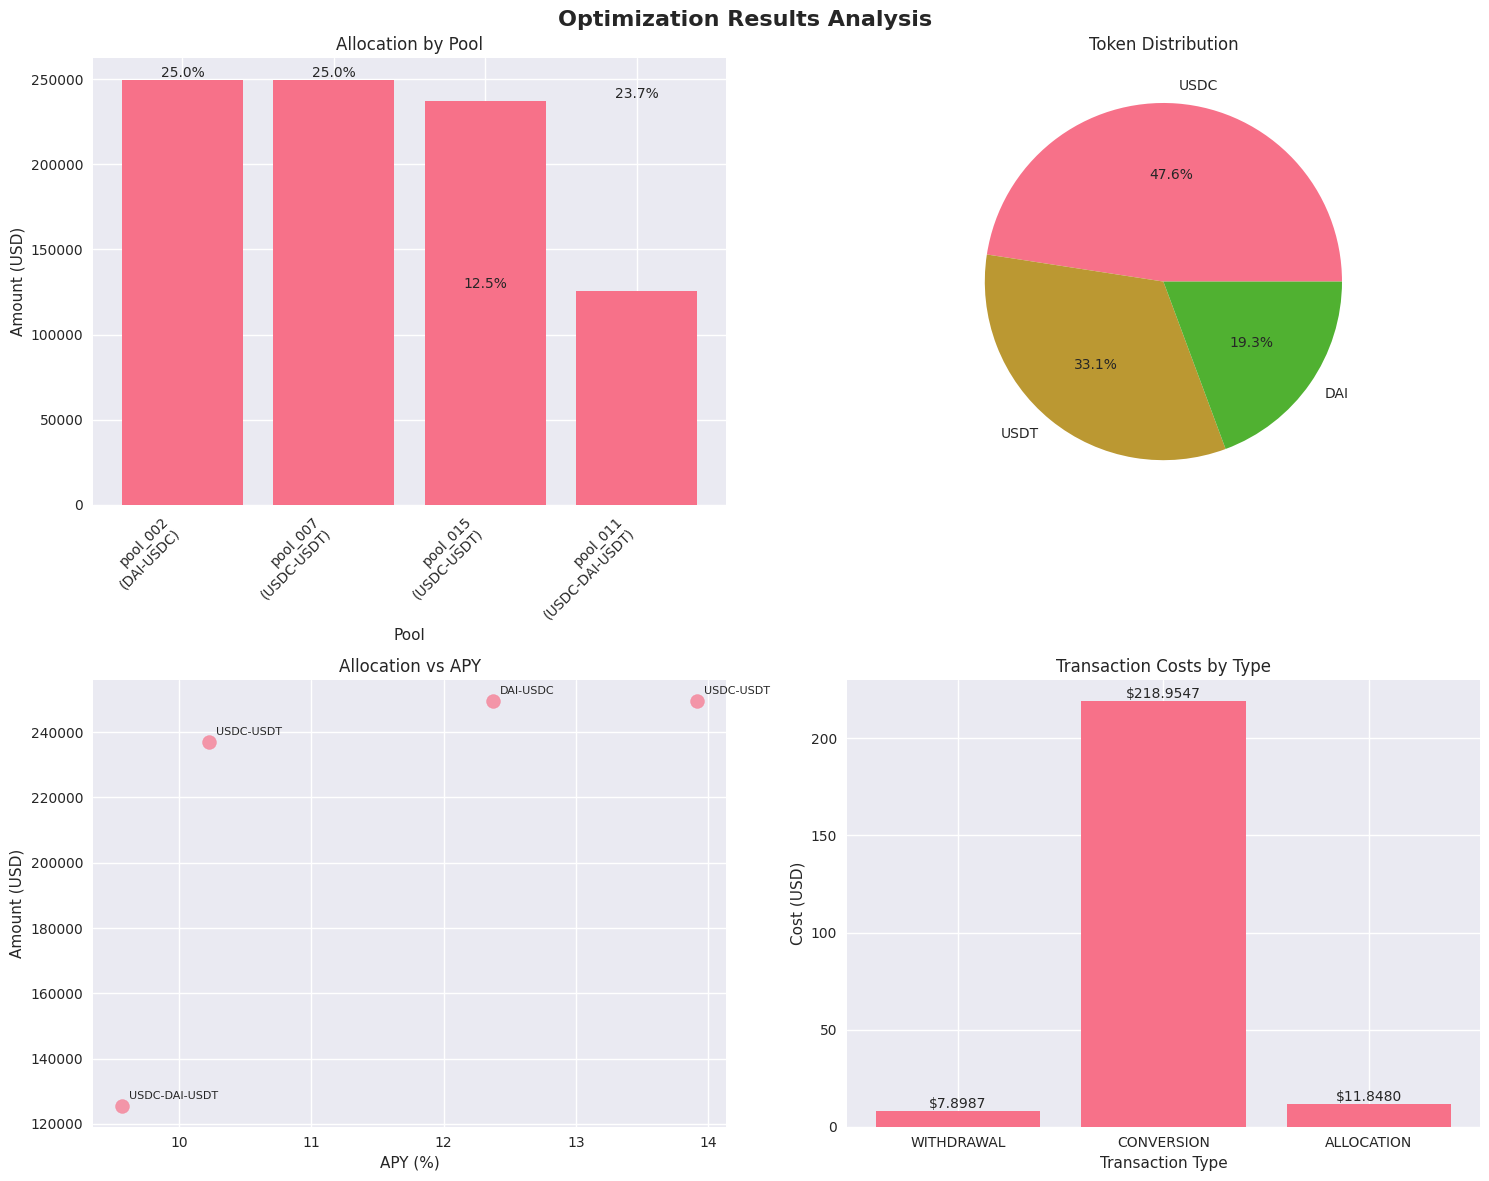

In [9]:
if success:
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Optimization Results Analysis', fontsize=16, fontweight='bold')
    
    # 1. Allocation by pool
    pool_data = []
    for pool_id, pool_info in formatted_results["final_allocations"].items():
        pool_total = sum(token_data['amount_usd'] for token_data in pool_info["tokens"].values())
        pool_data.append({
            'pool': f"{pool_id}\n({pool_info['pool_symbol']})",
            'amount_usd': pool_total,
            'percentage': pool_total / optimizer.total_aum * 100
        })
    
    pool_df = pd.DataFrame(pool_data)
    pool_df = pool_df.sort_values('amount_usd', ascending=False)
    
    axes[0, 0].bar(range(len(pool_df)), pool_df['amount_usd'])
    axes[0, 0].set_title('Allocation by Pool')
    axes[0, 0].set_xlabel('Pool')
    axes[0, 0].set_ylabel('Amount (USD)')
    axes[0, 0].set_xticks(range(len(pool_df)))
    axes[0, 0].set_xticklabels(pool_df['pool'], rotation=45, ha='right')
    
    # Add percentage labels on bars
    for i, row in pool_df.iterrows():
        axes[0, 0].text(i, row['amount_usd'], f"{row['percentage']:.1f}%", 
                       ha='center', va='bottom')
    
    # 2. Token distribution
    token_dist = {}
    for pool_id, pool_info in formatted_results["final_allocations"].items():
        for token, token_data in pool_info["tokens"].items():
            if token not in token_dist:
                token_dist[token] = 0
            token_dist[token] += token_data['amount_usd']
    
    # Add unallocated tokens
    for token, token_data in formatted_results["unallocated_tokens"].items():
        if token not in token_dist:
            token_dist[token] = 0
        token_dist[token] += token_data['amount_usd']
    
    tokens_df = pd.DataFrame(list(token_dist.items()), columns=['token', 'amount_usd'])
    tokens_df = tokens_df.sort_values('amount_usd', ascending=False)
    
    axes[0, 1].pie(tokens_df['amount_usd'], labels=tokens_df['token'], autopct='%1.1f%%')
    axes[0, 1].set_title('Token Distribution')
    
    # 3. APY distribution
    apy_data = []
    for pool_id, pool_info in formatted_results["final_allocations"].items():
        pool_total = sum(token_data['amount_usd'] for token_data in pool_info["tokens"].values())
        pool_row = pools_df[pools_df['pool_id'] == pool_id].iloc[0]
        apy_data.append({
            'pool': pool_info['pool_symbol'],
            'apy': pool_row['forecasted_apy'],
            'amount_usd': pool_total
        })
    
    apy_df = pd.DataFrame(apy_data)
    
    axes[1, 0].scatter(apy_df['apy'], apy_df['amount_usd'], s=100, alpha=0.7)
    axes[1, 0].set_title('Allocation vs APY')
    axes[1, 0].set_xlabel('APY (%)')
    axes[1, 0].set_ylabel('Amount (USD)')
    
    # Add pool labels
    for _, row in apy_df.iterrows():
        axes[1, 0].annotate(row['pool'], (row['apy'], row['amount_usd']), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 4. Transaction cost breakdown
    txn_types = ['WITHDRAWAL', 'CONVERSION', 'ALLOCATION']
    txn_costs = []
    
    for txn_type in txn_types:
        type_txns = [t for t in transactions if t['type'] == txn_type]
        total_cost = sum(t.get('total_cost_usd', 0) for t in type_txns)
        txn_costs.append(total_cost)
    
    axes[1, 1].bar(txn_types, txn_costs)
    axes[1, 1].set_title('Transaction Costs by Type')
    axes[1, 1].set_xlabel('Transaction Type')
    axes[1, 1].set_ylabel('Cost (USD)')
    
    # Add cost labels on bars
    for i, cost in enumerate(txn_costs):
        axes[1, 1].text(i, cost, f"${cost:.4f}", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No visualizations available - optimization failed")

## 8. Backtesting Scenarios

This section provides different scenarios to test the optimization algorithm under various conditions.

In [10]:
def run_scenario(scenario_name, custom_overrides=None, custom_pool_params=None, existing_pools_df=None):
    """Run a backtesting scenario with custom parameters.
    
    Args:
        scenario_name: Name of scenario
        custom_overrides: Custom allocation parameter overrides
        custom_pool_params: Custom pool generation parameters
        existing_pools_df: Existing pools DataFrame to use (if None, generate new)
        
    Returns:
        Dict: Scenario results
    """
    print(f"\n{'='*80}")
    print(f"RUNNING SCENARIO: {scenario_name}")
    print(f"{'='*80}")
    
    # Always create a generator instance
    generator = MockDataGenerator(seed=42)
    
    # Generate custom data if provided
    if custom_pool_params:
        pools_df = generator.generate_pools(**custom_pool_params)
        
        # Extract tokens
        tokens = set()
        for _, row in pools_df.iterrows():
            underlying_tokens = json.loads(row['underlying_tokens'])
            tokens.update(underlying_tokens)
        tokens = list(tokens)
        tokens.append('ETH')
        
        # Generate other data
        token_prices = generator.generate_token_prices(tokens)
        warm_wallet, current_allocations = generator.generate_balances(tokens)
    else:
        # Use existing data
        pools_df = existing_pools_df if existing_pools_df is not None else pools_df
        tokens = list(set([t for sublist in [json.loads(ut) for ut in pools_df['underlying_tokens']] for t in sublist]))
        tokens.append('ETH')
        
        # Use existing prices and balances if available, otherwise generate
        if 'token_prices' in globals():
            token_prices = globals()['token_prices']
            warm_wallet = globals()['warm_wallet']
            current_allocations = globals()['current_allocations']
        else:
            token_prices = generator.generate_token_prices(tokens)
            warm_wallet, current_allocations = generator.generate_balances(tokens)
    
    # Generate parameters with overrides
    alloc_params = generator.generate_allocation_parameters(custom_overrides)
    
    # Initialize optimizer
    optimizer = AllocationOptimizer(
        pools_df=pools_df,
        token_prices=token_prices,
        warm_wallet=warm_wallet,
        current_allocations=current_allocations,
        gas_fees=gas_fees,
        alloc_params=alloc_params
    )
    
    # Solve optimization
    start_time = time.time()
    success = optimizer.solve(verbose=False)
    solve_time = time.time() - start_time
    
    if not success:
        return {
            'scenario': scenario_name,
            'success': False,
            'solve_time': solve_time,
            'error': 'Optimization failed'
        }
    
    # Extract results
    results = optimizer.format_results()
    
    # Calculate metrics
    total_allocated = sum(
        sum(token_data['amount_usd'] for token_data in pool_data["tokens"].values())
        for pool_data in results["final_allocations"].values()
    )
    
    total_unallocated = sum(
        token_data['amount_usd'] for token_data in results["unallocated_tokens"].values()
    )
    
    total_cost = sum(txn.get('total_cost_usd', 0) for txn in results["transactions"])
    
    # Calculate weighted average APY
    weighted_apy = 0
    for pool_id, pool_data in results["final_allocations"].items():
        pool_total = sum(token_data['amount_usd'] for token_data in pool_data["tokens"].values())
        pool_row = pools_df[pools_df['pool_id'] == pool_id].iloc[0]
        pool_apy = pool_row['forecasted_apy']
        weighted_apy += pool_total * pool_apy
    
    if total_allocated > 0:
        weighted_apy /= total_allocated
    
    return {
        'scenario': scenario_name,
        'success': True,
        'solve_time': solve_time,
        'total_aum': optimizer.total_aum,
        'total_allocated': total_allocated,
        'total_unallocated': total_unallocated,
        'total_cost': total_cost,
        'num_pools': len(results["final_allocations"]),
        'num_transactions': len(results["transactions"]),
        'weighted_apy': weighted_apy,
        'allocation_pct': total_allocated / optimizer.total_aum,
        'cost_pct': total_cost / optimizer.total_aum,
        'results': results
    }

print("✓ Scenario runner function defined")

✓ Scenario runner function defined


In [11]:
# Define backtesting scenarios
scenarios = [
    {
        'name': 'Baseline',
        'overrides': {},
        'pool_params': None
    },
    {
        'name': 'High Max Allocation',
        'overrides': {'max_alloc_percentage': 0.5},  # 50% max per pool
        'pool_params': None
    },
    {
        'name': 'Low TVL Limit',
        'overrides': {'tvl_limit_percentage': 0.01},  # 1% of pool TVL
        'pool_params': None
    },
    {
        'name': 'High Conversion Cost',
        'overrides': {'conversion_rate': 0.001},  # 0.1% conversion fee
        'pool_params': None
    },
    {
        'name': 'Many Small Pools',
        'overrides': {},
        'pool_params': {'num_pools': 30}
    },
    {
        'name': 'Few Large Pools',
        'overrides': {},
        'pool_params': {'num_pools': 5}
    }
]

# Run all scenarios
scenario_results = []

for scenario in scenarios:
    result = run_scenario(
        scenario['name'],
        scenario['overrides'],
        scenario['pool_params'],
        pools_df  # Pass the existing pools_df for scenarios that don't generate new pools
    )
    scenario_results.append(result)
    
    if result['success']:
        print(f"✓ {scenario['name']} completed successfully")
        print(f"  Solve time: {result['solve_time']:.3f}s")
        print(f"  Allocation: {result['allocation_pct']:.2%}")
        print(f"  Weighted APY: {result['weighted_apy']:.2f}%")
        print(f"  Cost: {result['cost_pct']:.4%}")
    else:
        print(f"✗ {scenario['name']} failed: {result.get('error', 'Unknown error')}")

2025-12-07 22:26:45,934 - asset_allocation.optimize_allocations - INFO - Token universe: 3 tokens - ['DAI', 'USDC', 'USDT']
2025-12-07 22:26:45,935 - asset_allocation.optimize_allocations - INFO - Total AUM: $999,729.21
2025-12-07 22:26:45,936 - asset_allocation.optimize_allocations - INFO - Optimizer initialized: 15 pools, 3 tokens, AUM=$999,729.21
2025-12-07 22:26:45,936 - asset_allocation.optimize_allocations - INFO - Parameters: max_alloc=25.0% ($249,932.30 per pool), tvl_limit=5.0%, conversion_rate=0.0400%
2025-12-07 22:26:45,937 - asset_allocation.optimize_allocations - INFO - Building optimization model...
2025-12-07 22:26:45,966 - asset_allocation.optimize_allocations - INFO - Model built with 318 constraints
2025-12-07 22:26:45,968 - asset_allocation.optimize_allocations - INFO - Solving with HIGHS...



RUNNING SCENARIO: Baseline


/home/geokoumpa/.asdf/installs/python/3.11.11/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:407: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
2025-12-07 22:26:46,417 - asset_allocation.optimize_allocations - INFO - ✓ Optimization successful: optimal
2025-12-07 22:26:46,418 - asset_allocation.optimize_allocations - INFO -   Objective value: $228.1536 daily yield
2025-12-07 22:26:46,427 - asset_allocation.optimize_allocations - INFO - Extracted 9 allocations and 17 transactions
2025-12-07 22:26:46,428 - asset_allocation.optimize_allocations - INFO - Formatted results: 4 pools, 0 unallocated tokens, 17 transactions
2025-12-07 22:26:46,432 - asset_allocation.optimize_allocations - INFO - Token universe: 3 tokens - ['DAI', 'USDC', 'USDT']
2025-12-07 22:26:46,433 - asset_allocation.optimize_allocations - INFO - Total AUM: $999,729.21
2025-12-07 22:26:46

✓ Baseline completed successfully
  Solve time: 0.485s
  Allocation: 86.20%
  Weighted APY: 11.82%
  Cost: 0.0239%

RUNNING SCENARIO: High Max Allocation


2025-12-07 22:26:46,866 - asset_allocation.optimize_allocations - INFO - ✓ Optimization successful: optimal
2025-12-07 22:26:46,866 - asset_allocation.optimize_allocations - INFO -   Objective value: $262.3364 daily yield
2025-12-07 22:26:46,875 - asset_allocation.optimize_allocations - INFO - Extracted 4 allocations and 12 transactions
2025-12-07 22:26:46,876 - asset_allocation.optimize_allocations - INFO - Formatted results: 2 pools, 0 unallocated tokens, 12 transactions
2025-12-07 22:26:46,878 - asset_allocation.optimize_allocations - INFO - Token universe: 3 tokens - ['DAI', 'USDC', 'USDT']
2025-12-07 22:26:46,879 - asset_allocation.optimize_allocations - INFO - Total AUM: $999,729.21
2025-12-07 22:26:46,880 - asset_allocation.optimize_allocations - INFO - Optimizer initialized: 15 pools, 3 tokens, AUM=$999,729.21
2025-12-07 22:26:46,880 - asset_allocation.optimize_allocations - INFO - Parameters: max_alloc=25.0% ($249,932.30 per pool), tvl_limit=1.0%, conversion_rate=0.0400%
2025-

✓ High Max Allocation completed successfully
  Solve time: 0.436s
  Allocation: 86.20%
  Weighted APY: 13.27%
  Cost: 0.0146%

RUNNING SCENARIO: Low TVL Limit


2025-12-07 22:26:47,365 - asset_allocation.optimize_allocations - INFO - ✓ Optimization successful: optimal
2025-12-07 22:26:47,366 - asset_allocation.optimize_allocations - INFO -   Objective value: $214.1871 daily yield
2025-12-07 22:26:47,375 - asset_allocation.optimize_allocations - INFO - Extracted 10 allocations and 18 transactions
2025-12-07 22:26:47,376 - asset_allocation.optimize_allocations - INFO - Formatted results: 5 pools, 0 unallocated tokens, 18 transactions
2025-12-07 22:26:47,379 - asset_allocation.optimize_allocations - INFO - Token universe: 3 tokens - ['DAI', 'USDC', 'USDT']
2025-12-07 22:26:47,380 - asset_allocation.optimize_allocations - INFO - Total AUM: $999,729.21
2025-12-07 22:26:47,380 - asset_allocation.optimize_allocations - INFO - Optimizer initialized: 15 pools, 3 tokens, AUM=$999,729.21
2025-12-07 22:26:47,381 - asset_allocation.optimize_allocations - INFO - Parameters: max_alloc=25.0% ($249,932.30 per pool), tvl_limit=5.0%, conversion_rate=0.1000%
2025

✓ Low TVL Limit completed successfully
  Solve time: 0.489s
  Allocation: 86.25%
  Weighted APY: 11.22%
  Cost: 0.0171%

RUNNING SCENARIO: High Conversion Cost


2025-12-07 22:26:47,763 - asset_allocation.optimize_allocations - INFO - ✓ Optimization successful: optimal
2025-12-07 22:26:47,764 - asset_allocation.optimize_allocations - INFO -   Objective value: $228.1536 daily yield
2025-12-07 22:26:47,773 - asset_allocation.optimize_allocations - INFO - Extracted 9 allocations and 17 transactions
2025-12-07 22:26:47,774 - asset_allocation.optimize_allocations - INFO - Formatted results: 4 pools, 0 unallocated tokens, 17 transactions
2025-12-07 22:26:47,780 - asset_allocation.optimize_allocations - INFO - Token universe: 3 tokens - ['DAI', 'USDC', 'USDT']
2025-12-07 22:26:47,782 - asset_allocation.optimize_allocations - INFO - Total AUM: $998,141.04
2025-12-07 22:26:47,783 - asset_allocation.optimize_allocations - INFO - Optimizer initialized: 30 pools, 3 tokens, AUM=$998,141.04
2025-12-07 22:26:47,783 - asset_allocation.optimize_allocations - INFO - Parameters: max_alloc=25.0% ($249,535.26 per pool), tvl_limit=5.0%, conversion_rate=0.0400%
2025-

✓ High Conversion Cost completed successfully
  Solve time: 0.387s
  Allocation: 86.20%
  Weighted APY: 11.82%
  Cost: 0.0324%

RUNNING SCENARIO: Many Small Pools


2025-12-07 22:26:48,627 - asset_allocation.optimize_allocations - INFO - ✓ Optimization successful: optimal
2025-12-07 22:26:48,628 - asset_allocation.optimize_allocations - INFO -   Objective value: $341.4649 daily yield
2025-12-07 22:26:48,645 - asset_allocation.optimize_allocations - INFO - Extracted 11 allocations and 20 transactions
2025-12-07 22:26:48,647 - asset_allocation.optimize_allocations - INFO - Formatted results: 5 pools, 0 unallocated tokens, 20 transactions
2025-12-07 22:26:48,650 - asset_allocation.optimize_allocations - INFO - Token universe: 3 tokens - ['DAI', 'USDC', 'USDT']
2025-12-07 22:26:48,651 - asset_allocation.optimize_allocations - INFO - Total AUM: $1,000,214.30
2025-12-07 22:26:48,651 - asset_allocation.optimize_allocations - INFO - Optimizer initialized: 5 pools, 3 tokens, AUM=$1,000,214.30
2025-12-07 22:26:48,652 - asset_allocation.optimize_allocations - INFO - Parameters: max_alloc=25.0% ($250,053.58 per pool), tvl_limit=5.0%, conversion_rate=0.0400%
2

✓ Many Small Pools completed successfully
  Solve time: 0.853s
  Allocation: 99.98%
  Weighted APY: 15.02%
  Cost: 0.0092%

RUNNING SCENARIO: Few Large Pools
✓ Few Large Pools completed successfully
  Solve time: 0.154s
  Allocation: 74.93%
  Weighted APY: 9.24%
  Cost: 0.0829%


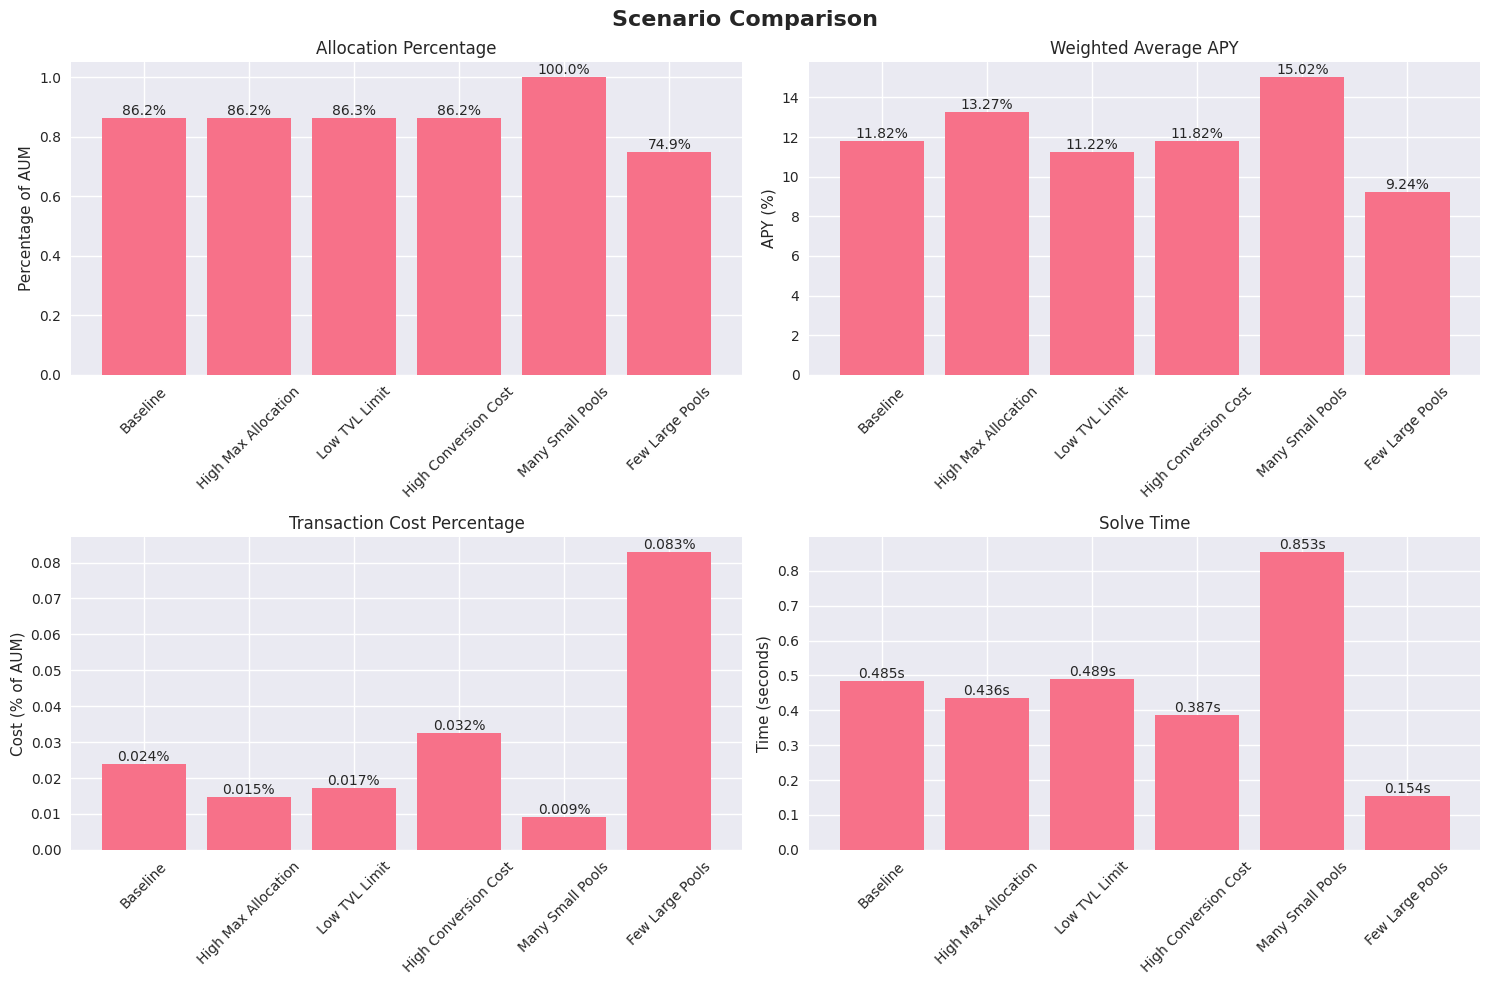


SCENARIO COMPARISON TABLE:


,scenario,allocation_pct,weighted_apy,cost_pct,solve_time,num_pools
0,Baseline,86.20%,11.82%,0.0239%,0.485s,4
1,High Max Allocation,86.20%,13.27%,0.0146%,0.436s,2
2,Low TVL Limit,86.25%,11.22%,0.0171%,0.489s,5
3,High Conversion Cost,86.20%,11.82%,0.0324%,0.387s,4
4,Many Small Pools,99.98%,15.02%,0.0092%,0.853s,5
5,Few Large Pools,74.93%,9.24%,0.0829%,0.154s,3


In [12]:
# Compare scenarios
successful_results = [r for r in scenario_results if r['success']]

if successful_results:
    comparison_df = pd.DataFrame(successful_results)
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Scenario Comparison', fontsize=16, fontweight='bold')
    
    # 1. Allocation percentage
    axes[0, 0].bar(comparison_df['scenario'], comparison_df['allocation_pct'])
    axes[0, 0].set_title('Allocation Percentage')
    axes[0, 0].set_ylabel('Percentage of AUM')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Add percentage labels
    for i, pct in enumerate(comparison_df['allocation_pct']):
        axes[0, 0].text(i, pct, f"{pct:.1%}", ha='center', va='bottom')
    
    # 2. Weighted APY
    axes[0, 1].bar(comparison_df['scenario'], comparison_df['weighted_apy'])
    axes[0, 1].set_title('Weighted Average APY')
    axes[0, 1].set_ylabel('APY (%)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Add APY labels
    for i, apy in enumerate(comparison_df['weighted_apy']):
        axes[0, 1].text(i, apy, f"{apy:.2f}%", ha='center', va='bottom')
    
    # 3. Cost percentage
    axes[1, 0].bar(comparison_df['scenario'], comparison_df['cost_pct'] * 100)
    axes[1, 0].set_title('Transaction Cost Percentage')
    axes[1, 0].set_ylabel('Cost (% of AUM)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Add cost labels
    for i, cost in enumerate(comparison_df['cost_pct']):
        axes[1, 0].text(i, cost * 100, f"{cost*100:.3f}%", ha='center', va='bottom')
    
    # 4. Solve time
    axes[1, 1].bar(comparison_df['scenario'], comparison_df['solve_time'])
    axes[1, 1].set_title('Solve Time')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Add time labels
    for i, time_val in enumerate(comparison_df['solve_time']):
        axes[1, 1].text(i, time_val, f"{time_val:.3f}s", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Display comparison table
    print("\nSCENARIO COMPARISON TABLE:")
    display_cols = ['scenario', 'allocation_pct', 'weighted_apy', 'cost_pct', 'solve_time', 'num_pools']
    display_df = comparison_df[display_cols].copy()
    display_df['allocation_pct'] = display_df['allocation_pct'].apply(lambda x: f"{x:.2%}")
    display_df['cost_pct'] = display_df['cost_pct'].apply(lambda x: f"{x:.4%}")
    display_df['weighted_apy'] = display_df['weighted_apy'].apply(lambda x: f"{x:.2f}%")
    display_df['solve_time'] = display_df['solve_time'].apply(lambda x: f"{x:.3f}s")
    
    display(display_df)
    
else:
    print("No successful scenarios to compare")

## 9. Custom Scenario Testing

Use this section to test your own custom scenarios and parameter configurations.

In [13]:
# Example: Test a custom scenario
# Modify these parameters to test your own scenarios

custom_overrides = {
    'max_alloc_percentage': 0.3,      # 30% max per pool
    'tvl_limit_percentage': 0.03,     # 3% of pool TVL
    'conversion_rate': 0.0005,        # 0.05% conversion fee
    'min_transaction_value': 100.0    # $100 minimum transaction
}

custom_pool_params = {
    'num_pools': 25  # Generate 25 pools
}

# Run custom scenario
custom_result = run_scenario(
    'Custom Scenario',
    custom_overrides,
    custom_pool_params
)

if custom_result['success']:
    print(f"✓ Custom scenario completed successfully")
    print(f"  Total AUM: ${custom_result['total_aum']:,.2f}")
    print(f"  Allocation: {custom_result['allocation_pct']:.2%}")
    print(f"  Weighted APY: {custom_result['weighted_apy']:.2f}%")
    print(f"  Cost: ${custom_result['total_cost']:.4f} ({custom_result['cost_pct']:.4%})")
    print(f"  Pools used: {custom_result['num_pools']}")
    print(f"  Transactions: {custom_result['num_transactions']}")
else:
    print(f"✗ Custom scenario failed: {custom_result.get('error', 'Unknown error')}")

2025-12-07 22:26:49,209 - asset_allocation.optimize_allocations - INFO - Token universe: 3 tokens - ['DAI', 'USDC', 'USDT']
2025-12-07 22:26:49,211 - asset_allocation.optimize_allocations - INFO - Total AUM: $1,000,416.35
2025-12-07 22:26:49,212 - asset_allocation.optimize_allocations - INFO - Optimizer initialized: 25 pools, 3 tokens, AUM=$1,000,416.35
2025-12-07 22:26:49,212 - asset_allocation.optimize_allocations - INFO - Parameters: max_alloc=30.0% ($300,124.90 per pool), tvl_limit=3.0%, conversion_rate=0.0500%
2025-12-07 22:26:49,213 - asset_allocation.optimize_allocations - INFO - Building optimization model...
2025-12-07 22:26:49,319 - asset_allocation.optimize_allocations - INFO - Model built with 514 constraints
2025-12-07 22:26:49,321 - asset_allocation.optimize_allocations - INFO - Solving with HIGHS...



RUNNING SCENARIO: Custom Scenario


/home/geokoumpa/.asdf/installs/python/3.11.11/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:407: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
2025-12-07 22:26:49,925 - asset_allocation.optimize_allocations - INFO - ✓ Optimization successful: optimal
2025-12-07 22:26:49,926 - asset_allocation.optimize_allocations - INFO -   Objective value: $330.4306 daily yield
2025-12-07 22:26:49,942 - asset_allocation.optimize_allocations - INFO - Extracted 8 allocations and 14 transactions
2025-12-07 22:26:49,943 - asset_allocation.optimize_allocations - INFO - Formatted results: 4 pools, 0 unallocated tokens, 14 transactions


✓ Custom scenario completed successfully
  Total AUM: $1,000,416.35
  Allocation: 99.98%
  Weighted APY: 13.70%
  Cost: $201.3011 (0.0201%)
  Pools used: 4
  Transactions: 14


## 10. Export Results

Export backtesting results for further analysis.

In [14]:
# Export scenario results to CSV
if successful_results:
    results_df = pd.DataFrame(successful_results)
    
    # Select columns for export
    export_cols = [
        'scenario', 'total_aum', 'total_allocated', 'total_unallocated',
        'total_cost', 'num_pools', 'num_transactions', 'weighted_apy',
        'allocation_pct', 'cost_pct', 'solve_time'
    ]
    
    export_df = results_df[export_cols].copy()
    
    # Save to CSV
    export_df.to_csv('backtesting_results.csv', index=False)
    print("✓ Results exported to backtesting_results.csv")
    
    # Display export preview
    print("\nExport preview:")
    display(export_df.head())
    
    # Save detailed results for each scenario
    for result in successful_results:
        scenario_name = result['scenario'].replace(' ', '_').lower()
        
        # Save allocations
        if result['results']['final_allocations']:
            allocations_data = []
            for pool_id, pool_data in result['results']['final_allocations'].items():
                for token, token_data in pool_data['tokens'].items():
                    allocations_data.append({
                        'scenario': result['scenario'],
                        'pool_id': pool_id,
                        'pool_symbol': pool_data['pool_symbol'],
                        'token': token,
                        'amount': token_data['amount'],
                        'amount_usd': token_data['amount_usd']
                    })
            
            alloc_df = pd.DataFrame(allocations_data)
            alloc_df.to_csv(f'allocations_{scenario_name}.csv', index=False)
        
        # Save transactions
        if result['results']['transactions']:
            txn_df = pd.DataFrame(result['results']['transactions'])
            txn_df['scenario'] = result['scenario']
            txn_df.to_csv(f'transactions_{scenario_name}.csv', index=False)
    
    print("✓ Detailed allocations and transactions exported for each scenario")
    
else:
    print("No results to export")

✓ Results exported to backtesting_results.csv

Export preview:


,scenario,total_aum,total_allocated,total_unallocated,total_cost,num_pools,num_transactions,weighted_apy,allocation_pct,cost_pct,solve_time
0,Baseline,999729.209962,861757.015361,0,238.701336,4,17,11.821351,0.861990,0.000239,0.485277
1,High Max Allocation,999729.209962,861762.392417,0,146.196848,2,12,13.269093,0.861996,0.000146,0.436093
2,Low TVL Limit,999729.209962,862299.144180,0,170.864525,5,18,11.222736,0.862533,0.000171,0.489124
3,High Conversion Cost,999729.209962,861757.015361,0,323.931221,4,17,11.821351,0.861990,0.000324,0.387325
4,Many Small Pools,998141.044266,997971.949390,0,92.110820,5,20,15.016536,0.999831,0.000092,0.853041


✓ Detailed allocations and transactions exported for each scenario


## 11. Next Steps

### For Data Scientists:

1. **Modify Mock Data**: Adjust `MockDataGenerator` class to create more realistic scenarios based on your market knowledge

2. **Add Custom Scenarios**: Create your own scenarios in section 9 to test specific market conditions or parameter configurations

3. **Integrate Real Data**: Replace mock data with real historical data by connecting to your database

4. **Extended Analysis**: Add more sophisticated analysis like:
   - Monte Carlo simulations
   - Sensitivity analysis
   - Risk metrics calculation
   - Performance attribution

5. **Parameter Optimization**: Use this framework to find optimal parameter settings for different market regimes

### Integration with Production:

To integrate this with the production system:

1. Replace mock data generators with actual database queries from `asset_allocation/optimize_allocations.py`

2. Use the same parameter structure as the production system

3. Implement the same result storage mechanism

4. Add monitoring and alerting for optimization performance

### Key Files to Reference:

- `asset_allocation/optimize_allocations.py`: Main optimization implementation
- `asset_allocation/data_quality_report.py`: Data quality validation
- `database/schema/`: Database schema definitions
- `config.py`: Configuration parameters

### Contact Information:

For questions about the optimization algorithm or integration, refer to the project documentation or contact the development team.